In [8]:
pwd

'/Users/yueyingteng/Documents/text_object_detection'

In [9]:
import pandas as pd
import numpy as np
import re
import os 
from PIL import Image 


In [47]:
# the following is training hello data 

df = pd.read_csv('./data/labelbox_full_hello.csv')
# drop the row with skip as label 
df = df[['External ID', 'Label']].drop(2)
df.rename(columns = {'External ID': 'id', 'Label': 'label'}, inplace = True)

# remove duplication in id
df = df[~ df.duplicated('id', keep = 'first')]

df.head()


,id,label
0,IMG_0258.JPG,"{""Hello"":[[{""x"":1812,""y"":1792},{""x"":1812,""y"":7..."
1,IMG_0329.JPG,"{""Hello"":[[{""x"":2470,""y"":1359},{""x"":2470,""y"":1..."
4,IMG_0360.JPG,"{""Hello"":[[{""x"":1918,""y"":1524},{""x"":1918,""y"":9..."
5,IMG_0260.JPG,"{""Hello"":[[{""x"":2163,""y"":1601},{""x"":2163,""y"":7..."
6,IMG_0514.JPG,"{""Hello"":[[{""x"":1839,""y"":1496},{""x"":1839,""y"":8..."


In [48]:
df.shape

(173, 2)

In [49]:
# find width and height of all images in External ID

# training 
img_dir = '/Users/yueyingteng/Documents/text_object_detection/images/'
img_files = df['id']
w = []
h = []
files = []
xmin = []
ymin = []
xmax = []
ymax = []

for i in range(len(img_files)):
    try:
        image_path = os.path.join(img_dir, img_files[i])
        image_obj = Image.open(image_path)
        
        # get image width and height 
        w.append(image_obj.width)
        h.append(image_obj.height)
        files.append(img_files[i])
        
        # get coordinates
        string =  df['label'].iloc[i]
        # match all numbers in lable column which ahs coordinates for all four corners with bottom left corner as origin
        match = re.findall(r'\:\d+', string)
        # xmin is 1812
        match1 = re.findall(r'\d+', match[0])
        xmin.append(int(match1[0]))
        # ymin is H-1792
        match2 = re.findall(r'\d+', match[1])
        ymin.append(image_obj.height - int(match2[0]))
        # xmax is 2061
        match3 = re.findall(r'\d+', match[4])
        xmax.append(int(match3[0]))
        # ymax is H-785
        match4 = re.findall(r'\d+', match[3])
        ymax.append(image_obj.height - int(match4[0]))

    except KeyError: 
        continue 

True

In [50]:
classes = ['hello'] * len(files)

out = pd.DataFrame({'filename': files, 'width': w, 'height': h, 'class': classes, 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax},\
                  columns = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])
out.head()

out.to_csv('hello_label.csv', index = None)


In [51]:
df2 = pd.read_csv('hello_label.csv')

df2.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG_0258.JPG,4032,3024,hello,1812,1232,2061,2239
1,IMG_0329.JPG,4032,3024,hello,2470,1665,2694,2002
2,IMG_0360.JPG,4032,3024,hello,1839,1528,2125,2178
3,IMG_0260.JPG,4032,3024,hello,1943,1542,2205,2083
4,IMG_0514.JPG,4032,3024,hello,1917,1282,2179,2366


### split label into train test data 

In [52]:
# grouped = df2.groupby('filename')
# grouped.apply(lambda x: len(x)).value_counts()

# split each file into a group in a list
gb = df2.groupby('filename')

grouped_list = [gb.get_group(x) for x in gb.groups]

# gb.groups is a dictionary 
print (gb.get_group('IMG_0258.JPG'))

len(grouped_list)


       filename  width  height  class  xmin  ymin  xmax  ymax
0  IMG_0258.JPG   4032    3024  hello  1812  1232  2061  2239


170

In [57]:
# split filenames to train test groups
train_index = np.random.choice(len(grouped_list), size=140, replace=False)
# np.setdiff1d - Find the set difference of two arrays.
test_index = np.setdiff1d(list(range(170)), train_index)

print (len(train_index), len(test_index))

# group datasets using index
train = pd.concat([grouped_list[i] for i in train_index])
test = pd.concat([grouped_list[i] for i in test_index])

print (len(train), len(test))

train.to_csv('./data/train_labels.csv', index=None)
test.to_csv('./data/test_labels.csv', index=None)


140 30
140 30


### draw boxes

In [ ]:

def draw_boxes(image_name):
    selected_value = full_labels[full_labels.filename == image_name]
    img = cv2.imread('images/{}'.format(image_name))
    for index, row in selected_value.iterrows():
        img = cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 255, 0), 3)
    return img

In [ ]:

Image.fromarray(draw_boxes('raccoon-1.jpg'))

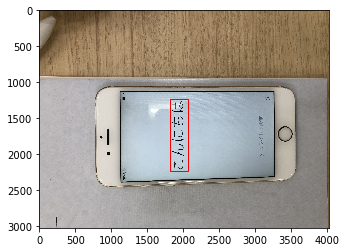

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


one_dir = '/Users/yueyingteng/Documents/text_object_detection/images/IMG_0258.JPG'
im = np.array(Image.open(one_dir), dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch 
# rect = patches.Rectangle((1772, 1230), 2110 - 1772, 2280 - 1230,linewidth=1,edgecolor='r',facecolor='none')
rect = patches.Rectangle((1812, 1232), 2061 - 1812, 2239 - 1232,linewidth=1,edgecolor='r',facecolor='none')


# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [88]:
string = df['label'].iloc[0]
print (string)

match = re.findall(r'\:\d+', string)
print (match)

# xmin is 1812
match1 = re.findall(r'\d+', match[0])
int(match1[0])

# ymin is H-1792
match2 = re.findall(r'\d+', match[1])
int(match2[0])

# xmax is 2061
match3 = re.findall(r'\d+', match[4])
int(match3[0])

# ymax is H-785
match4 = re.findall(r'\d+', match[3])
int(match4[0])

{"Hello":[[{"x":1812,"y":1792},{"x":1812,"y":785},{"x":2061,"y":785},{"x":2061,"y":1792}]]}


[':1812', ':1792', ':1812', ':785', ':2061', ':785', ':2061', ':1792']